In [8]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import datetime
import datetime as dt
import numpy as np
import random
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
#from matplotlib.ticker import PercentFormatter
from scipy.stats import norm
import quandl
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
sns.set_style("ticks")

In [9]:

g = quandl.get("WIKI/NFLX",start_date="2016-10-17", end_date="2018-11-15")
print(g.ix[:, 3])

LimitExceededError: (Status 429) (Quandl Error QELx01) You have exceeded the anonymous user limit of 50 calls per day. To make more calls today, please register for a free Quandl account and then include your API key with your requests.

In [15]:
# Quandl API calls
import sys
import os 
quandl.ApiConfig.api_key = "1FHran9s_sz2z6Vxgkvy"

def equalizer(lists):
    '''
    We want all of these lists to be the length of the shortest list.
    '''
    lengths = []
    for li_st in lists:
        lengths.append(len(li_st))
    length = min(lengths)
    new_lists = []
    for li_st in lists:
        new_lists.append(li_st[0:length])
    return new_lists

#Equity Data
def Stock_Data(tickers):
    stocks = []
    stock_labels = []
    for i,k in tickers.items():
        WIKI_string = ("WIKI/"+i)
        data = quandl.get(WIKI_string,start_date="2017-1-17", end_date="2018-11-15")
        array = np.array(data.iloc[:,3])
        stocks.append(array)
        stock_labels.append(k)
#        plt.plot(array,label=k)
#        plt.legend()

#BEFORE YOU COLUMN STACK MAKE SURE STOCKS IS THE SAME LENGTH
    stocks = equalizer(stocks)

    stock_twoD = np.column_stack(stocks)
    stocks_DF = pd.DataFrame(stock_twoD,columns=stock_labels)
        
    return stocks_DF, stock_labels

stock_basket = {"LUV":"Southwest Airlines", "INTC":"Intel", "AMZN":"Amazon", "GS":"Goldman Sachs"}
stock_portfolio, stock_labels = Stock_Data(stock_basket)
stock_portfolio.head()

#Currencies
tickers = ("EURAUD","EURMXN",'EURUSD','EURTRY')
def ECB_Data(tickers):
    '''
    Pulls in data using quandl
    '''
    ecb_pairs = []
    for i in tickers:
        x = ("ECB/"+i)
        data = quandl.get(x,start_date="2017-1-17", end_date="2018-11-15")
        array = np.array(data)
        ecb_pairs.append(array)
    return ecb_pairs

def fred_data(tickers):
    '''
    Pulls in data using quandl
    '''
    fred_pairs = []
    fred_labels = []
    for i,k in tickers.items():
        fred_string = ("FRED/"+i)
        data = quandl.get(fred_string,start_date="2016-10-17", end_date="2018-11-15")
        array = np.array(data)
        fred_pairs.append(array)
        fred_labels.append(k)
#         plt.plot(array,label=k)
#         plt.legend()
    two_d_pairs = np.column_stack(fred_pairs)
    fred_pairs_DF = pd.DataFrame(two_d_pairs,columns=fred_labels)
        
    return fred_pairs_DF, fred_labels

fred_tickers = {"DEXUSAL":"AUD/USD","DEXUSUK":"GBP/USD", "DEXCAUS": "USD/CAD", "DEXUSEU": "EUR/USD", "DEXJPUS": "USD/JPY", "DEXMXUS":"USD/MXN"}
fred_pairs,fred_labels = fred_data(fred_tickers)
#fred_pairs.head(10)
fred_pairs

,AUD/USD,GBP/USD,USD/CAD,EUR/USD,USD/JPY,USD/MXN
0,0.7626,1.2186,1.3135,1.1000,103.96,18.8850
1,0.7679,1.2310,1.3105,1.0997,103.80,18.6575
2,0.7715,1.2279,1.3105,1.0966,103.30,18.5605
3,0.7640,1.2256,1.3197,1.0934,103.92,18.5910
4,0.7597,1.2210,1.3324,1.0866,103.96,18.6315
5,0.7603,1.2204,1.3387,1.0888,104.20,18.5835
6,0.7652,1.2164,1.3333,1.0890,104.25,18.4850
7,0.7657,1.2234,1.3361,1.0916,104.42,18.6680
8,0.7606,1.2173,1.3385,1.0904,105.14,18.8140
9,0.7578,1.2155,1.3383,1.0934,105.40,18.7170


In [10]:
#### Reading in Euro/Dollar Exchange Quotes
euro1 = pd.read_csv("eurcsv.csv")
jpy1 = pd.read_csv("jpy.csv")
crude1  = pd.read_csv("Crude.csv")
intc1 = pd.read_csv("intc.csv")
nflx1 = pd.read_csv("nflx.csv")
emini1 = pd.read_csv("e-mini.csv")


#Defining Dates and Closing Prices
euro = euro1['Price']
jpy = jpy1['Price']
#crude = crude1['Price']
intc = intc1["Adj Close"]
nflx = nflx1["Adj Close"]
e_mini = emini1['Price']
x = np.linspace(0,1,814)
plt.plot(x,e_mini)

print(len(e_mini))

print(len(jpy))


FileNotFoundError: File b'Crude.csv' does not exist

In [11]:
#Stru

def zero(basket):
    data  = np.copy(basket)
    hold = []
    for i in range(len(data)):
        lens = len(data[i])
        hold.append(lens)
    max_length = np.max(hold)
    for i in range(len(data)):
        while len(data[i]) <= max_length-1:
            replaced = np.insert(data[i],len(data[i]),0)
            data[i] = replaced
    stacked = np.column_stack(data)
    return stacked


def combine(structured_rets):
    combined_returns = []
    for i in range(len(structured_rets)):
        num_zeros = (structured_rets[[i],:] == 0).sum()
        column_sum = sum(structured_rets[i])
        length = len(structured_rets[i])
        average = column_sum/(length)
        combined_returns.append(average)
    
    running_sum = np.cumsum(combined_returns)
    return combined_returns



In [12]:
def tester(price_in,technical,long_or_short):
    buys = []
    shorts = []
    rets = []
    s_rets = []
    benchmark = []
    twenty_six = price_in.ewm(span=26).mean()
    twelve = price_in.ewm(span=12).mean()
    macd = twelve - twenty_six
    delta_macd = macd.pct_change(periods=2)
    slope = []

    if long_or_short == "long":
        for i in range(len(price_in)-1):
            if delta_macd[i] > technical:
                buys.append(i)
    else:
        for i in range(len(price_in)-1):
            if delta_macd[i] < technical:
                shorts.append(i)
    for i in buys:
        j = int(i)
        j1 = int(i+1)
        returns = ((price_in[j1] - price_in[j])/price_in[j])*100
        rets.append(returns)
    for i in shorts:
        s = int(i)
        s1 = int(i+1)
        s_returns = ((price_in[s1] - price_in[s])/price_in[s])*-100
        s_rets.append(s_returns)
    
#    plt.plot(np.cumsum(rets))
    if long_or_short == "long":
        total_return = np.cumsum(rets)
        std_rets = np.std(rets)
        end_return1 = total_return[-1]
        mean_returns = np.mean(rets)
        VAR_95 = (norm.ppf(1-0.95,mean_returns, std_rets))*-1
        end_return = (end_return1)/VAR_95
        
    else:
        total_return = np.cumsum(s_rets)
        end_return = total_return[-1]
        std_s_rets = np.std(s_rets)
        end_return1 = total_return[-1]
        mean_returns = np.mean(s_rets)
        VAR_95 = (norm.ppf(1-0.95,mean_returns, std_s_rets))*-1
        end_return = (end_return1)/VAR_95

    max_macd = np.percentile(delta_macd[5:],85)
    min_macd = np.percentile(delta_macd[5:],15)

    return end_return, total_return, min_macd, max_macd

def random_walker(n,ls,close):
    '''
    A function to randomly select n different values which are all tested and compared to find the best indicator
    '''
    starter = [0]    
    test_return, indicator, min_ind, max_ind = tester(close,starter[-1],str(ls))
    for i in range(n):
        test_x = np.random.uniform(min_ind,max_ind)
        random_return, indicator, minn,maxx = tester(close,test_x,str(ls))
        if random_return > test_return:
            starter.append(test_x)
            test_return, notimportant, minn,maxx = random_return, indicator, minn,maxx
#     x,y,minn,maxx = tester(close,starter[-1],str(ls))
        
    return starter[-1]

In [13]:
def back_testing(price_in,long_indicator,short_indicator):
    buys = []
    shorts = []
    rets = []
    s_rets = []
    benchmark = []
    twenty_six = price_in.ewm(span=26).mean()
    twelve = price_in.ewm(span=12).mean()
    macd = twelve - twenty_six
    delta_macd = macd.pct_change(periods=2)
    mix = []
    mix_port = []
    slope = []
    for i in range(len(macd)):
        if i == 0:
            slope.append(i)
        else:
            temp_slope = macd[i]-macd[i-1]
            slope.append(temp_slope)

    for i in range(len(price_in)-1):
        if delta_macd[i] > long_indicator:
            buys.append(i)
            mix.append(i)
        elif delta_macd[i] < short_indicator:
            shorts.append(i)
            mix.append(i)
    for i in buys:
        j = int(i)
        j1 = int(i+1)
        returns = ((price_in[j1] - price_in[j])/price_in[j])*100
        rets.append(returns)
    for i in shorts:
        s = int(i)
        s1 = int(i+1)
        s_returns = ((price_in[s1] - price_in[s])/price_in[s])*-100
        s_rets.append(s_returns)
#     for i in mix:
#         j = int(i)
#         j1 = int(i+1)
#         mix_return = ((price_in[j1] - price_in[j])/price_in[j])*100
#         mix_port.append(mix_return)        
        
#     for i in range(len(price_in)-1):
#         z = int(i)
#         z1 = int(i+1)
#         base = ((price_in[z1] - price_in[z])/price_in[z])*100
#         benchmark.append(base)

#     x_bench = np.linspace(0,1,len(benchmark))
    x_strat = np.linspace(0,1,len(rets))   
    x_short = np.linspace(0,1,len(s_rets))
    mix_port = np.concatenate((rets,s_rets))
    x_mix = np.linspace(0,1,len(mix_port))
#    fig, ax = plt.subplots(figsize=(12,5))

#     ax.plot(x_strat, np.cumsum(rets),label="Long Strategy")
#     ax.plot(x_bench, np.cumsum(benchmark),label="Benchmark")
#     ax.plot(x_short, np.cumsum(s_rets),label="Short Strategy")
#     ax.plot(x_mix, np.cumsum(mix_port),label="Mix Portfolio")

# #    ax2 = ax.twinx()
# #    ax2.plot(np.linspace(0,1,len(macd)), macd, 'r')
#     ax.yaxis.set_major_formatter(PercentFormatter())    
#     ax.legend(fontsize=15)
#     print("Strategy Return = %",sum(rets))
#     print("Total Return Outright = %",sum(benchmark))
    
#     #RISK ASSESMENT BENCHMARK
#     delta_returns = price_in.pct_change()
#     mean_returns = np.mean(delta_returns)
#     std_returns = np.std(delta_returns)
#     VAR_95 = norm.ppf(1-0.95,mean_returns, std_returns)*100
#     print("Benchmark VAR @ confidence Level = 95% Level", VAR_95)
    
#     #RISK ASSESMENT STRATEGY
#     #delta_returns_strat = price_in.pct_change()
#     mean_returns_strat = np.mean(rets)
#     std_returns_strat = np.std(rets)
#     VAR_95_strat = norm.ppf(1-0.95,mean_returns_strat, std_returns_strat)
#    print("Strategy VAR @ confidence Level = 95% Level", VAR_95_strat)
    return mix_port



In [14]:
#labels = ("Euro/USD","NFLX","USD/JPY","Crude","E-Mini")
def best_indicator(n,prices,labels):
    long_ind = random_walker(n,"long",prices)
    short_ind = random_walker(n,"short",prices)
    returns = back_testing(prices,long_ind,short_ind)
    plt.plot(np.cumsum(returns),label=labels)
    plt.legend(fontsize=14)
    return returns
plt.figure(figsize=(15,5))

def portfolio_sim(n, portfolio, labels):
    basket = []
    for i in range(portfolio.shape[1]):
        column = str(labels[i])
        best_sim = best_indicator(n,portfolio[column], column)
        basket.append(best_sim)
        
    return basket

d = portfolio_sim(10,stock_portfolio,stock_labels)
        
        

#euro_returns = best_indicator(150,euro,"Euro/USD")
# nflx_returns = best_indicator(150,nflx,"NFLX")
# #intc_returns = best_indicator(100,intc)
# jpy_returns = best_indicator(150,jpy,"JPY/USD")
# crude_returns = best_indicator(150,crude,"Crude")
# e_mini_returns = best_indicator(150,e_mini,"S&P E-Mini Futures")
    


NameError: name 'stock_portfolio' is not defined

In [ ]:
#port_returns = (euro_returns,nflx_returns,jpy_returns,crude_returns,e_mini_returns)

structured_returns = zero(d)
total_returns = combine(structured_returns)
cum_returns = np.cumsum(total_returns)

plt.figure(figsize=(14,4))

plt.plot(np.cumsum(total_returns))
roi = cum_returns[-1]/(len(cum_returns)/253)
print(cum_returns[-1])
print(roi)


## SMA/LMA 

In [65]:
def SMALMAtester(price_in,SMA_ind,LMA_ind,long_or_short):
    
    ''' 
    
    Tests the short term moving average (SMA) and long term moving average (LMA) indicators for the given prices. Can
    specify if you are using a short or a long strategy.
    
    Inputs:
    
    Price_in: Pandas df of price data
    SMA_ind: Window for the short term moving average
    LMA_ind: Window for the short term moving average
    Long_or_short: Indicates whether you are testing the long or short strategy
    
    Returns: End return (risk adjusted), total return, max/min for SMA, max/min for LMA
    
    '''
    
    #create lists of buys, shorts, returns, and calculate the rolling averages (SMA/LMA) for price_in
    buys = []
    shorts = []
    rets = []
    s_rets = []
    benchmark = []
    LMA = price_in.rolling(window=LMA_ind).mean()
    SMA = price_in.rolling(window=SMA_ind).mean()
    diff = SMA - LMA
    delta_MA = diff.pct_change(periods=2)
    
    
    # decides if you are using a long or short strategy and buys or shorts based on input
    if long_or_short == "long":
        for i in range(len(price_in)-1):
            if diff[i] > 0:
                buys.append(i)
    else:
        for i in range(len(price_in)-1):
            if diff[i] < 0:
                shorts.append(i)
                
    # calculates returns for buys/shorts
    for i in buys:
        j = int(i)
        j1 = int(i+1)
        returns = ((price_in[j1] - price_in[j])/price_in[j])*100
        rets.append(returns)
    for i in shorts:
        s = int(i)
        s1 = int(i+1)
        s_returns = ((price_in[s1] - price_in[s])/price_in[s])*-100
        s_rets.append(s_returns)
    
#    plt.plot(np.cumsum(rets))
    if long_or_short == "long":
        total_return = np.cumsum(rets)
        std_rets = np.std(rets)
        end_return1 = total_return[-1]
        mean_returns = np.mean(rets)
        VAR_95 = (norm.ppf(1-0.95,mean_returns, std_rets))*-1
        end_return = (end_return1)/VAR_95
        
    else:
        total_return = np.cumsum(s_rets)
        end_return = total_return[-1]
        std_s_rets = np.std(s_rets)
        end_return1 = total_return[-1]
        mean_returns = np.mean(s_rets)
        VAR_95 = (norm.ppf(1-0.95,mean_returns, std_s_rets))*-1
        end_return = (end_return1)/VAR_95

    #provides mins/maxes for the random walker below for the average windows
    max_SMA = 50
    min_SMA = 5
    max_LMA = 200
    min_LMA = 50

    return end_return, total_return, max_SMA, min_SMA,max_LMA ,min_LMA


In [66]:
def random_walkerSMALMA(n,ls,close):
    
    ''' 
    
    Using a random walker, the function tests the short term moving average (SMA) and long term moving average (LMA) and tries
    find the best one via brute force.
    
    Inputs:
    
    n: Number of iterations
    ls: Either long or short based on what you want to test
    close: Price data
    
    Returns: The best values for the SMA/LMA windows based on the results from the random walker
    
    '''
    #initialize starter values for the walker
    starter = [5] 
    starter2 = [50] #will need two starters to make this work and update functions and the like
    test_return, indicator, max_SMA, min_SMA,max_LMA ,min_LMA = SMALMAtester(close,starter[-1],starter2[-1],str(ls))
    
    # random walker: generates random integers between min/maxes for the SMA/LMA and then appends if they are better than the last
    for i in range(n):
        test_SMA = np.random.randint(min_SMA,max_SMA)
        test_LMA = np.random.randint(min_LMA,max_LMA)
        random_return, indicator, max_SMA, min_SMA,max_LMA ,min_LMA = SMALMAtester(close,test_SMA,test_LMA,str(ls))
        test_return, notimportant, max_SMA, min_SMA,max_LMA ,min_LMA = SMALMAtester(close,starter[-1],starter2[-1],str(ls))
        if random_return > test_return:
            starter.append(test_SMA)
            starter2.append(test_LMA)
            test_return, notimportant, max_SMA, min_SMA,max_LMA ,min_LMA = random_return, indicator, max_SMA, min_SMA,max_LMA ,min_LMA
        
    return starter[-1] , starter2[-1]

random_walkerSMALMA(3,"long",e_mini)

(25, 167)

In [67]:
def back_testingSMALMA(price_in,SMA_ind,LMA_ind,SMA_indshort,LMA_indshort): #may not need the short ind here as they are not used
    
    ''' 
    
    Creates a mixed portfolio and back tests the strategy on price data based on the indicators you provide.
    
    Inputs:
    
    Price_in: Pandas df of price data
    SMA_ind: Window for the short term moving average
    LMA_ind: Window for the short term moving average
    SMA_indshort: Window for the short term moving average #MAY NOT NEED
    LMA_indshort: Window for the short term moving average

    
    Returns: Mixed portfolio returns
    
    '''
        
    buys = []
    shorts = []
    rets = []
    s_rets = []
    benchmark = []
    LMA = price_in.rolling(window=LMA_ind).mean()
    SMA = price_in.rolling(window=SMA_ind).mean()
    diff = SMA - LMA
    delta_MA = diff.pct_change(periods=2)
    mix = []
    mix_port = []
    slope = []
    for i in range(len(diff)):
        if i == 0:
            slope.append(i)
        else:
            temp_slope = diff[i]-diff[i-1]
            slope.append(temp_slope)

    for i in range(len(price_in)-1):
        if diff[i] > 0:
            buys.append(i)
            mix.append(i)
        elif diff[i] < 0:
            shorts.append(i)
            mix.append(i)
    for i in buys:
        j = int(i)
        j1 = int(i+1)
        returns = ((price_in[j1] - price_in[j])/price_in[j])*100
        rets.append(returns)
    for i in shorts:
        s = int(i)
        s1 = int(i+1)
        s_returns = ((price_in[s1] - price_in[s])/price_in[s])*-100
        s_rets.append(s_returns)
        x_strat = np.linspace(0,1,len(rets))   
    x_short = np.linspace(0,1,len(s_rets))
    mix_port = np.concatenate((rets,s_rets))
    x_mix = np.linspace(0,1,len(mix_port))

    return mix_port

In [68]:
def best_indicatorSMALMA(n,prices,labels):
    
    ''' 
    
    A compilation function for the above functions. Using a random walker and the tester function within random_walker,
    the function tests the short term moving average (SMA) and long term moving average (LMA) and tries
    find the best one via brute force. Then plots the cumulative returns.
    
    Inputs:
    
    n: Number of iterations
    prices: Price data for the security
    labels for each security: Price data
    
    Returns: A plot of the returns as well as the return themselves
    
    '''
    
    #insert random walker function call and code here that simulates different windows for the rolling mean
    SMA,LMA = random_walkerSMALMA(n,"long",prices)
    SMAshort,LMAshort = random_walkerSMALMA(n,"short",prices)
    #back tests based on random walker outputs
    returns = back_testingSMALMA(prices,SMA,LMA,SMAshort,LMAshort)
    #plots the returns and returns the returns
    plt.plot(np.cumsum(returns),label=labels)
    plt.legend(fontsize=14)
    return returns
plt.figure(figsize=(15,5))



def portfolio_sim_SMA(n, portfolio, labels):
    ''' 
    
    A compilation function for the above functions which simulates a portfolio for the securities using the best_indicator function.
    
    Inputs:
    
    n: Number of iterations
    portfolio: Price data for various securities
    labels: Labels for the securities
    
    Returns: 
    
    '''
    
    basket = []
    for i in range(portfolio.shape[1]):
        column = str(labels[i])
        best_sim = best_indicatorSMALMA(n,portfolio[column], column)
        basket.append(best_sim)
        
    return basket

portfolio_sim_SMA(4, stock_portfolio, stock_labels)

C:\Users\jackb\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\jackb\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\jackb\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: index -1 is out of bounds for axis 0 with size 0

<Figure size 1080x360 with 0 Axes>

In [16]:
def Meantester(price_in,LMA_ind,long_or_short):
    buys = []
    shorts = []
    rets = []
    s_rets = []
    benchmark = []
    mean = price_in.rolling(window=LMA_ind).mean()

#    diff = SMA - LMA
#    delta_MA = diff.pct_change(periods=2)
    slope = []
#     for i in range(len(macd)):
#         if i == 0:
#             slope.append(i)
#         else:
#             temp_slope = macd[i]-macd[i-1]
#             slope.append(temp_slope)
    if long_or_short == "long":
        for i in range(len(price_in)-1):
            if price_in[i] < mean[i]:
                buys.append(i)
    else:
        for i in range(len(price_in)-1):
            if price_in[i] > mean[i]:
                shorts.append(i)
    for i in buys:
        j = int(i)
        j1 = int(i+1)
        returns = ((price_in[j1] - price_in[j])/price_in[j])*100
        rets.append(returns)
    for i in shorts:
        s = int(i)
        s1 = int(i+1)
        s_returns = ((price_in[s1] - price_in[s])/price_in[s])*-100
        s_rets.append(s_returns)
    
#    plt.plot(np.cumsum(rets))
    if long_or_short == "long":
        total_return = np.cumsum(rets)
        std_rets = np.std(rets)
        end_return1 = total_return[-1]
        mean_returns = np.mean(rets)
        VAR_95 = (norm.ppf(1-0.95,mean_returns, std_rets))*-1
        end_return = (end_return1)/VAR_95
        
    else:
        total_return = np.cumsum(s_rets)
        end_return = total_return[-1]
        std_s_rets = np.std(s_rets)
        end_return1 = total_return[-1]
        mean_returns = np.mean(s_rets)
        VAR_95 = (norm.ppf(1-0.95,mean_returns, std_s_rets))*-1
        end_return = (end_return1)/VAR_95

    max_M = 100
    min_M = 10

    return end_return, total_return, max_M, min_M


In [17]:
def back_testingMean(price_in,LMA_ind,):
    buys = []
    shorts = []
    rets = []
    s_rets = []
    benchmark = []
    mean = price_in.rolling(window=LMA_ind).mean()

#    diff = SMA - LMA
#    delta_MA = diff.pct_change(periods=2)
    mix = []
    mix_port = []
    slope = []
    for i in range(len(mean)):
        if i == 0:
            slope.append(i)
        else:
            temp_slope = mean[i]-mean[i-1]
            slope.append(temp_slope)

    for i in range(len(price_in)-1):
        if price_in[i] < mean[i]:
            buys.append(i)
            mix.append(i)
        elif price_in[i] > mean[i]:
            shorts.append(i)
            mix.append(i)
    for i in buys:
        j = int(i)
        j1 = int(i+1)
        returns = ((price_in[j1] - price_in[j])/price_in[j])*100
        rets.append(returns)
    for i in shorts:
        s = int(i)
        s1 = int(i+1)
        s_returns = ((price_in[s1] - price_in[s])/price_in[s])*-100
        s_rets.append(s_returns)
#     for i in mix:
#         j = int(i)
#         j1 = int(i+1)
#         mix_return = ((price_in[j1] - price_in[j])/price_in[j])*100
#         mix_port.append(mix_return)        
        
#     for i in range(len(price_in)-1):
#         z = int(i)
#         z1 = int(i+1)
#         base = ((price_in[z1] - price_in[z])/price_in[z])*100
#         benchmark.append(base)

#     x_bench = np.linspace(0,1,len(benchmark))
    x_strat = np.linspace(0,1,len(rets))   
    x_short = np.linspace(0,1,len(s_rets))
    mix_port = np.concatenate((rets,s_rets))
    x_mix = np.linspace(0,1,len(mix_port))
#    fig, ax = plt.subplots(figsize=(12,5))

#     ax.plot(x_strat, np.cumsum(rets),label="Long Strategy")
#     ax.plot(x_bench, np.cumsum(benchmark),label="Benchmark")
#     ax.plot(x_short, np.cumsum(s_rets),label="Short Strategy")
#     ax.plot(x_mix, np.cumsum(mix_port),label="Mix Portfolio")

# #    ax2 = ax.twinx()
# #    ax2.plot(np.linspace(0,1,len(macd)), macd, 'r')
#     ax.yaxis.set_major_formatter(PercentFormatter())    
#     ax.legend(fontsize=15)
#     print("Strategy Return = %",sum(rets))
#     print("Total Return Outright = %",sum(benchmark))
    
#     #RISK ASSESMENT BENCHMARK
#     delta_returns = price_in.pct_change()
#     mean_returns = np.mean(delta_returns)
#     std_returns = np.std(delta_returns)
#     VAR_95 = norm.ppf(1-0.95,mean_returns, std_returns)*100
#     print("Benchmark VAR @ confidence Level = 95% Level", VAR_95)
    
#     #RISK ASSESMENT STRATEGY
#     #delta_returns_strat = price_in.pct_change()
#     mean_returns_strat = np.mean(rets)
#     std_returns_strat = np.std(rets)
#     VAR_95_strat = norm.ppf(1-0.95,mean_returns_strat, std_returns_strat)
#    print("Strategy VAR @ confidence Level = 95% Level", VAR_95_strat)
    return mix_port


In [18]:
#### We will need another version to vary the window instead of the indicator level

def random_walkerMean(n,ls,close):
    starter = [15]  
    x_start, indicator, max_M, min_M = Meantester(close,starter[-1],str(ls))
    for i in range(n):
        test_M = np.random.randint(min_M,max_M)
        random_return, indicator, max_M, min_M = Meantester(close,test_M,str(ls))
        test_return, notimportant, max_M, min_M = Meantester(close,starter[-1],str(ls))
        if random_return > test_return:
            starter.append(test_M)
    #x,y,minn,maxx = tester(close,starter[-1],starter2[-1],str(ls))
        
    return starter[-1]

In [19]:
def best_indicatorMean(n,prices,labels):
    #insert random walker function call and code here that simulates different windows for the rolling mean
    bestmean = random_walkerMean(n,"long",prices)
    returns = back_testingMean(prices,bestmean) #plugs those here in place of 20/100
    plt.plot(np.cumsum(returns),label=labels)
    plt.legend(fontsize=14)
    return returns
plt.figure(figsize=(15,5))


[array([-0.01767721, -1.85643564,  0.37831021, -0.03589375,  0.73608618,
         0.83764035, -2.13856486, -1.011378  , -0.21893815, -1.24337173,
         0.24069617,  1.07129664,  0.87719298,  0.19927536, -3.90526125,
         0.03762935,  0.69588114, -0.20545387, -3.20044919, -1.95282289,
         3.88483534, -1.76537585, -0.56038647,  0.11659541,  1.20341615,
         0.09589567, -2.01187967,  1.03637075,  1.04509386,  1.26412565,
         1.38074522,  0.65298507,  1.31603336, -0.56714233,  0.68077277,
        -1.15131579, -1.01682381,  1.32611132,  0.70046083,  0.54914882,
         0.34589478,  1.08853411,  0.28715004,  0.51896922, -0.33825886,
         0.01786352,  4.50080371, -1.81455271,  1.14581408, -1.58962178,
         0.24136651,  0.        ,  0.27782923,  0.701884  , -1.19222304,
        -0.76109152,  0.05611672, -0.448682  ,  0.93896714,  1.6372093 ,
         1.17151748, -0.10966916,  1.42726441,  2.87545788,  1.62126024,
        -2.92965423,  2.01789788, -0.42999656, -3.9

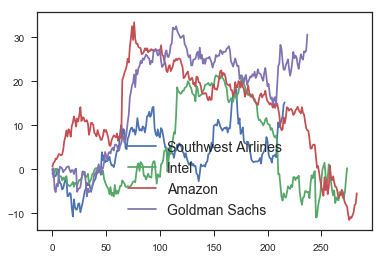

In [21]:
def portfolio_sim_mean(n, portfolio, labels):
    ''' 
    
    A compilation function for the above functions which simulates a portfolio for the securities using the best_indicator function.
    
    Inputs:
    
    n: Number of iterations
    portfolio: Price data for various securities
    labels: Labels for the securities
    
    Returns: 
    
    '''
    
    basket = []
    for i in range(portfolio.shape[1]):
        column = str(labels[i])
        best_sim = best_indicatorMean(n,portfolio[column], column)
        basket.append(best_sim)
        
    return basket

portfolio_sim_mean(4, stock_portfolio, stock_labels)